In [5]:
import pandas as pd
import numpy as np
from Functions import Cleaning_Functions
from sklearn import model_selection, linear_model, neighbors, preprocessing, metrics, ensemble

fun = Cleaning_Functions()

clean = pd.read_csv("../data/clean.csv")


In [6]:
def standarize_data(df):
        """
        Input: a dataset
        action: returns numeric column values scaled by mean and standard deviation
        """
        numeric_data = df.select_dtypes(include=['float64', 'int64'])
        for i in numeric_data.columns:
            df[i] = (df[i] - df[i].mean())/df[i].std()
        return df

In [63]:
market_data = fun.delete_id_columns(clean) #1
market_data, pred_market = fun.drop_response_rows_with_NAs(market_data, "Market_Orientation", "PPI_Likelihood") #2
market_data = fun.replace_NAN_with_na(market_data) #3
market_data = fun.entry_to_lowercase(market_data) #4
market_data = fun.remove_underscores_spaces(market_data) #5
market_data = fun.convert_to_categorical(market_data) #6
market_data = fun.impute_data(market_data)
market_data = standarize_data(market_data)


In [37]:
#Ana's fuc
def get_dummyXs_y(df, y_var):
    
    y = df[y_var]
    X  = df.drop(y_var, axis = 1)
    X_cat = X.select_dtypes(include = ["category", "O"])
    X_num = X.select_dtypes(include=['float64', 'int64'])
    
    X_cat_dummy = pd.get_dummies(X_cat)
    newX = pd.concat([X_num, X_cat_dummy], axis = 1)
    
    return newX, y

In [38]:
X, y = get_dummyXs_y(market_data, "Market_Orientation")
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 50)


NameError: name 'market_data' is not defined

In [39]:
def fit_predict(clf, X_tr, X_te, y_tr, y_te):
    clf.fit(X_tr,y_tr)
    pred = clf.predict(X_te)
    mse = metrics.mean_squared_error(y_te, pred)
    
    return "MSE: {} ".format(mse)



def tune_parameters(X_train, y_train, clf, param_dict, cv=5):
    
   
    
    best_model = model_selection.GridSearchCV(clf, param_dict, cv=cv, scoring = "neg_mean_squared_error", n_jobs =-1, verbose=3)
    
    best_model.fit(X_train, y_train)
    
    print("Best Parameters: {} \n Training MSE: {} \n Parameter Index: {}".format(best_model.best_params_,best_model.best_score_,best_model.best_index_) ) # best is alpha = 0


    #uses gridsearch, prints best parameters, best model, its MSE on the training set
    #returns classifer
    
    return clf

test_mse_market = []

Market Orientation
=======

## Random Forest Model

In [67]:
forest_model = ensemble.RandomForestRegressor()
fit_predict(forest_model, X_tr, X_te, y_tr, y_te)

parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20, 50], 'max_features':["auto", "sqrt", "log2"]}

best_forest = tune_parameters( X_tr, y_tr,forest_model, parameters)

forest_pred = best_forest.predict(X_te)
forest_test_mse_market = metrics.mean_squared_error(y_te, forest_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.7min finished


Best Parameters: {'max_depth': 50, 'max_features': 'auto', 'n_estimators': 200} 
 Training MSE: -0.010516094751742087 
 Parameter Index: 26


In [68]:
test_mse.append("Random Forrest Test MSE:{}".format(forest_test_mse))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, forest_pred)))

Test MSE: 0.004644118607085156


In [69]:

forest_importances = pd.Series(best_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
forest_importances


value_livestock_prod_consumed_USD_PPP_pHH_Yr    0.427205
farm_income_USD_PPP_pHH_Yr                      0.303100
value_crop_consumed_USD_PPP_pHH_Yr              0.127582
total_income_USD_PPP_pHH_Yr                     0.126198
value_farm_produce_USD_PPP_pHH_Yr               0.004343
                                                  ...   
crop_name_1_broadbeans                          0.000000
crop_name_1_achiote                             0.000000
crop_name_1_watermelon                          0.000000
crop_name_1_zucchini                            0.000000
crop_name_1_chickpeas                           0.000000
Length: 159, dtype: float64

## XG Boosting Model

In [70]:
XG_model = ensemble.GradientBoostingRegressor()
fit_predict(XG_model, X_tr, X_te, y_tr, y_te)


parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20,50]}

best_XG = tune_parameters( X_tr, y_tr,XG_model, parameters)

XG_pred = best_XG.predict(X_te)
XG_test_mse = metrics.mean_squared_error(y_te, XG_pred)


test_mse_market.append("XGBoost Test MSE:{}".format(XG_test_mse))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, XG_pred)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.9min finished


Best Parameters: {'max_depth': 10, 'n_estimators': 250} 
 Training MSE: -0.012467946363262442 
 Parameter Index: 3
Test MSE: 0.021677865365120983


In [71]:

XG_importances = pd.Series(best_XG.feature_importances_, index=X.columns).sort_values(ascending=False)
XG_importances


value_livestock_prod_consumed_USD_PPP_pHH_Yr    0.449191
farm_income_USD_PPP_pHH_Yr                      0.322268
value_crop_consumed_USD_PPP_pHH_Yr              0.131396
total_income_USD_PPP_pHH_Yr                     0.068298
value_farm_produce_USD_PPP_pHH_Yr               0.018361
                                                  ...   
crop_name_1_yam                                 0.000000
crop_name_1_wheat                               0.000000
crop_name_1_watermelon                          0.000000
crop_name_1_tomato                              0.000000
crop_name_1_pigeonpea                           0.000000
Length: 159, dtype: float64

PPI_Likelihood
=====

In [7]:
PPI_data = fun.delete_id_columns(clean) #1
PPI_data, pred_PPI = fun.drop_response_rows_with_NAs(PPI_data, "PPI_Likelihood", "Market_Orientation") #2
PPI_data = fun.replace_NAN_with_na(PPI_data) #3
PPI_data = fun.entry_to_lowercase(PPI_data) #4
PPI_data = fun.remove_underscores_spaces(PPI_data) #5
PPI_data = fun.convert_to_categorical(PPI_data) #6
PPI_data = fun.impute_data(PPI_data)
PPI_data = standarize_data(PPI_data)


X, y = get_dummyXs_y(PPI_data, "PPI_Likelihood")
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 50)

test_mse_ppi = []

NameError: name 'get_dummyXs_y' is not defined

In [73]:
forest_model = ensemble.RandomForestRegressor()
fit_predict(forest_model, X_tr, X_te, y_tr, y_te)

parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20, 50]}

best_forest = tune_parameters( X_tr, y_tr,forest_model, parameters)

forest_pred = best_forest.predict(X_te)
forest_test_mse_ppi = metrics.mean_squared_error(y_te, forest_pred)

test_mse_ppi.append("Random Forrest Test MSE:{}".format(forest_test_mse_ppi))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, forest_pred)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.8min finished


Best Parameters: {'max_depth': 20, 'n_estimators': 200} 
 Training MSE: -0.38538118741894906 
 Parameter Index: 6
Test MSE: 0.3931938260734791


In [74]:

forest_importances = pd.Series(best_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
forest_importances


Country_mali                0.163262
Country_zambia              0.142931
LivestockHoldings           0.056198
continent_africa            0.052077
HHsizemembers               0.044168
                              ...   
crop_name_1_custardapple    0.000000
crop_name_1_coriander       0.000000
crop_name_1_peas            0.000000
crop_name_1_lemons          0.000000
crop_name_1_tobacco         0.000000
Length: 154, dtype: float64

In [75]:
XG_model = ensemble.GradientBoostingRegressor()
fit_predict(XG_model, X_tr, X_te, y_tr, y_te)


parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 20)), 'max_depth': [10,20,50]}

best_XG = tune_parameters( X_tr, y_tr,XG_model, parameters)

XG_pred = best_XG.predict(X_te)
XG_test_mse = metrics.mean_squared_error(y_te, XG_pred)

test_mse_ppi.append("XGBoost Test MSE:{}".format(XG_test_mse))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, XG_pred)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 16.4min finished


Best Parameters: {'max_depth': 10, 'n_estimators': 120} 
 Training MSE: -0.3860526893646002 
 Parameter Index: 1
Test MSE: 0.4070801718035054


In [76]:
XG_importances = pd.Series(best_XG.feature_importances_, index=X.columns).sort_values(ascending=False)
XG_importances


Country_mali                0.250837
Country_zambia              0.215757
continent_africa            0.073566
HHsizemembers               0.066270
Country_malawi              0.059080
                              ...   
crop_name_1_sugarcane       0.000000
crop_name_1_sunflower       0.000000
crop_name_1_sweetpotato     0.000000
crop_name_1_tea             0.000000
crop_name_1_passionfruit    0.000000
Length: 154, dtype: float64

## Country Specific PPI Likeilhood

In [49]:
#produces a dictionary of country specific dataframes
country_dict={}
for country in PPI_data["Country"].values.unique():
    new_df = PPI_data[PPI_data["Country"].values  == country]
    country_dict[country] = new_df

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,livestock_prodsales_USD_PPP_pHH_Yr,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl,continent
5455,0.506586,maize,goodharvest,intercrop,0.043647,ghana,-0.254909,-0.182131,womansingle,primary,...,-0.005650,-0.013546,-0.012311,-0.295275,-0.017725,-0.035273,-0.563701,0.629550,-0.629550,africa
5456,2.00861,maize,badharvest,intercrop,0.043647,ghana,0.614497,0.570632,couple,primary,...,-0.017973,-0.018628,-0.012311,-0.970724,-0.017818,-0.036339,-0.563701,0.629550,-0.629550,africa
5457,-0.244425,maize,normalharvest,intercrop,0.043647,ghana,2.104907,2.002484,couple,primary,...,0.078439,0.021136,-0.012311,-0.718186,-0.017289,-0.034411,-0.563701,0.629550,-0.629550,africa
5458,0.506586,maize,badharvest,intercrop,0.043647,ghana,-0.130708,-0.138888,couple,primary,...,0.004521,-0.009351,-0.012311,1.378663,-0.017819,-0.036360,-0.563701,0.629550,-0.629550,africa
5459,1.2576,maize,goodharvest,intercrop,0.043647,ghana,0.241895,0.245502,couple,none,...,-0.020955,-0.019858,-0.012311,-1.172100,-0.017906,-0.036510,-0.563701,0.629550,-0.629550,africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10073,0.506586,maize,goodharvest,monoculture,1.064233,ghana,-0.006507,-0.124473,couple,primary,...,-0.002668,-0.012316,-0.012311,0.816631,-0.017804,-0.034581,2.107365,-0.575694,0.575694,africa
10074,2.00861,maize,goodharvest,monoculture,1.064233,ghana,-0.130708,-0.228579,couple,noschool,...,-0.020955,-0.019858,-0.012311,-0.167254,-0.017892,-0.034491,1.344203,0.629550,-0.629550,africa
10075,-0.244425,maize,badharvest,intercrop,1.064233,ghana,-0.503310,-0.481635,mansingle,noschool,...,-0.019563,-0.019284,-0.012311,-0.007621,-0.017891,-0.034942,-0.563701,-2.620626,2.620626,africa
10076,-0.244425,maize,badharvest,intercrop,1.064233,ghana,-0.503310,-0.497651,couple,noschool,...,-0.020955,-0.019858,-0.012311,-0.167254,-0.017869,-0.032573,-0.563701,0.629550,-0.629550,africa


In [164]:
#wrapper func
def country_model(country, y, clf, parameter_dict):
    """
    INPUT
    country: str, country name as appears in dataframe
    y: str, column name of response
    clf: scikitlearn clf, the scikit learn model to train 
    parameter_dict: dict, dictionary of model parameters
    
    OUTPUT
    country: str, country name as appears in dataframe
    clf: trained best model
    mse: test mse for this model
    index: the list of dummy varaible columns for that country
    """
    X,y = get_dummyXs_y(country_dict[country], y)
    X_tr,X_te,y_tr,y_te = model_selection.train_test_split(X,y, test_size=0.3, random_state=50)
    
    index = X.columns
    fit_predict(clf, X_tr,X_te,y_tr,y_te)
    
    best_clf = tune_parameters(X_tr, y_tr, clf, parameter_dict)
    
    best_pred = best_clf.predict(X_te)
    mse = metrics.mean_squared_error(y_te, best_pred)
    print(best_clf.feature_importances_.sort())
    print("\n \n {} \n Test MSE: {}".format(country, mse))
    
    return country, best_clf.feature_importances_, mse, index

In [104]:
country_dict["ghana"].shape

(594, 40)

In [165]:
forest_model = ensemble.RandomForestRegressor()
parameters= {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20, 50]}

#
#name, ghana_forrest, ghana_mse, index = country_model(country_dict["ghana"], "PPI_Likelihood",forest_model,parameters)
#for key in country_dict:


country_results= {}
for country in PPI_data["Country"].values.unique():
    country_results[country] =country_model(country,
                          "PPI_Likelihood",
                          forest_model,
                          parameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


Best Parameters: {'max_depth': 50, 'n_estimators': 200} 
 Training MSE: -0.4846940606986993 
 Parameter Index: 10
None

 
 tanzania 
 Test MSE: 0.48859250149294786
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.0s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 100} 
 Training MSE: -0.009042188377202337 
 Parameter Index: 4
None

 
 guatemala 
 Test MSE: 0.005410243155791343
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.3s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 250} 
 Training MSE: -0.55154692190575 
 Parameter Index: 3
None

 
 honduras 
 Test MSE: 0.29408919750919194
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.2s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 150} 
 Training MSE: -0.7093578688945587 
 Parameter Index: 5
None

 
 elsalvador 
 Test MSE: 0.8111514507689069
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.5s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 200} 
 Training MSE: -0.16573711540403896 
 Parameter Index: 6
None

 
 mali 
 Test MSE: 0.19461715124969006
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


Best Parameters: {'max_depth': 50, 'n_estimators': 200} 
 Training MSE: -0.5873543336507671 
 Parameter Index: 10
None

 
 burkinafaso 
 Test MSE: 0.6309566665011045
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.5s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 200} 
 Training MSE: -0.2598982218667641 
 Parameter Index: 10
None

 
 malawi 
 Test MSE: 0.34593878762806857
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   31.9s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 200} 
 Training MSE: -0.22679280918026698 
 Parameter Index: 2
None

 
 kenya 
 Test MSE: 0.24114098622095562
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.1s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 150} 
 Training MSE: -0.06397267415992283 
 Parameter Index: 1
None

 
 india 
 Test MSE: 0.046996260779667356
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.0s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 200} 
 Training MSE: -0.27257820596550336 
 Parameter Index: 2
None

 
 cambodia 
 Test MSE: 0.3200662843389884
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.0s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 100} 
 Training MSE: -0.4644037272883426 
 Parameter Index: 0
None

 
 vietnam 
 Test MSE: 0.30778916776240095
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.0s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 150} 
 Training MSE: -0.15140942867741616 
 Parameter Index: 9
None

 
 ethiopia 
 Test MSE: 0.16681064083834418
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.0s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 250} 
 Training MSE: -0.28144279485339696 
 Parameter Index: 3
None

 
 zambia 
 Test MSE: 0.21177758414342715
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.1s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 200} 
 Training MSE: -0.07488000591428692 
 Parameter Index: 6
None

 
 ghana 
 Test MSE: 0.0792666081246137
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.8s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 150} 
 Training MSE: -0.24274264294642517 
 Parameter Index: 9
None

 
 uganda 
 Test MSE: 0.1803971174913305
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.0s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 150} 
 Training MSE: -0.006745737036035248 
 Parameter Index: 9
None

 
 peru 
 Test MSE: 0.013190216737694898


In [337]:
country_feature = {}
for country in country_results:
    country_feature[country] = pd.Series(country_results[country][1], 
                                      index=country_results[country][3].values).sort_values(ascending=False)


In [359]:
df=pd.DataFrame(country_feature["mali"])
df.columns = ['values']
df.index

Index(['continent_southamerica', 'continent_centralamerica', 'continent_asia',
       'continent_africa', 'HFIAS_status_severelyfi',
       'HFIAS_status_moderatelyfi', 'HFIAS_status_mildlyfi',
       'HFIAS_status_foodsecure', 'Head_EducationLevel_secondary',
       'Head_EducationLevel_primary',
       ...
       'crop_name_1_coriander', 'crop_name_1_cotton', 'crop_name_1_cowpea',
       'crop_name_1_cowpealeaf', 'crop_name_1_custardapple',
       'crop_name_1_fieldpea', 'crop_name_1_flowers', 'crop_name_1_fodder',
       'crop_name_1_fonio', 'YEAR'],
      dtype='object', length=156)

In [352]:
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], index,rotation=45)

NameError: name 'importance' is not defined

ConversionError: Failed to convert value(s) to axis units: Index(['continent_southamerica', 'continent_centralamerica', 'continent_asia',
       'continent_africa', 'HFIAS_status_severelyfi',
       'HFIAS_status_moderatelyfi', 'HFIAS_status_mildlyfi',
       'HFIAS_status_foodsecure', 'Head_EducationLevel_secondary',
       'Head_EducationLevel_primary',
       ...
       'crop_name_1_coriander', 'crop_name_1_cotton', 'crop_name_1_cowpea',
       'crop_name_1_cowpealeaf', 'crop_name_1_custardapple',
       'crop_name_1_fieldpea', 'crop_name_1_flowers', 'crop_name_1_fodder',
       'crop_name_1_fonio', 'YEAR'],
      dtype='object', length=156)

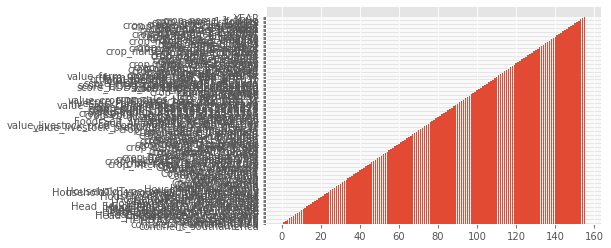

In [298]:
with sns.axes_style('white'):
    g = sns.factorplot(country_feature['ghana'].columns, data=country_feature['ghana'], aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)

C:\Users\chris\Miniconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\chris\Miniconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

[0]


TypeError: unhashable type: 'numpy.ndarray'

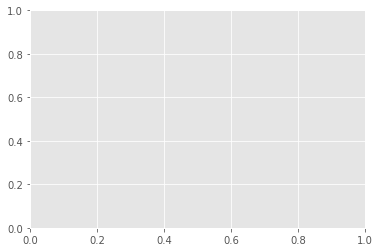

In [252]:
x_pos = [i for i, _ in enumerate(country_feature['ghana'][1].axes)]
print(x_pos)
plt.barh(country_feature['ghana'][1].axes,country_feature['ghana'][1].values, color='green')

plt.ylabel("Energy Source")
plt.xlabel("Energy Output (GJ)")
plt.title("Energy output from various fuel sources")

#plt.yticks(x_pos, x)

plt.show()

In [147]:
forest_importances = pd.Series(country_results["ghana"][1].feature_importances_[0:11], index=country_results["ghana"][3][0:11]).sort_values(ascending=False)
forest_importances

HHsizemembers                     0.143975
HHsizeMAE                         0.090831
NrofMonthsFoodInsecure            0.084394
score_HDDS_BadSeason              0.072846
LandCultivated                    0.053207
score_HDDS_GoodSeason             0.040023
LivestockHoldings                 0.030690
score_HDDS_farmbasedGoodSeason    0.015652
score_HDDS_purchasedGoodSeason    0.010233
LandOwned                         0.000000
YEAR                              0.000000
dtype: float64